# TensorFlow neural networks and evasion attacks

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import jdc

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import numpy as np
from matplotlib import pyplot as plt

from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod, LowProFool

# Dataset
-----
### Load MNIST dataset 

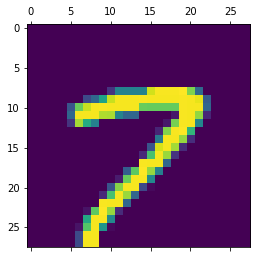

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

plt.matshow(x_train[123])
plt.show()

### Data preparation

In [3]:
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

# Neural network classifier
---
### TensorFlow model for digit recognition

In [4]:
class TfModel(Model):
    
    def __init__(self, filters=4, kernerl_size=4):
        super(TfModel, self).__init__()
        self.conv1 = Conv2D(filters=filters, kernel_size=kernerl_size, activation='relu')
        self.flatten = Flatten()
        self.dense1 = Dense(10, activation='softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.dense1(x)
        return x

### Neural network class for training. Metrics for training and testing

In [5]:
class NeuralNetworkTrainer():
    
    def __init__(self, model):
        self._model = model
        self._loss = tf.keras.losses.SparseCategoricalCrossentropy()
        self._optimizer = tf.keras.optimizers.Adam()
        
        self._train_loss = tf.keras.metrics.Mean(name='train_loss')
        self._train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

        self._test_loss = tf.keras.metrics.Mean(name='test_loss')
        self._test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
        
    def get_classifier(self, nb_classes, input_shape):
        return TensorFlowV2Classifier(
            model          = self._model,
            nb_classes     = nb_classes,
            input_shape    = input_shape, 
            loss_object    = self._loss,               
            clip_values    = (0, 1), 
            channels_first = False
        )

### Train method 

In [6]:
%%add_to NeuralNetworkTrainer

@tf.function
def _train(self, samples, labels):
    with tf.GradientTape() as tape:
        predictions = self._model(samples)
        loss = self._loss(labels, predictions)

    gradients = tape.gradient(loss, self._model.trainable_variables)
    self._optimizer.apply_gradients(zip(gradients, self._model.trainable_variables))
    self._train_loss(loss)
    self._train_accuracy(labels, predictions)

@tf.function
def _test(self, samples, labels):
    predictions = self._model(samples)
    loss = self._loss(labels, predictions)
    self._test_loss(loss)
    self._test_accuracy(labels, predictions)

def train(self, train_ds, test_ds, epoches):
    for epoch in range(epoches):
        for samples, labels in train_ds:
            self._train(samples, labels)

        for test_samples, test_labels in test_ds:
            self._test(test_samples, test_labels)

        print('Epoch {}, Train Accuraccy: {}, Test Accurracy: {}'.format(
            epoch+1, self._train_accuracy.result(), self._test_accuracy.result()))

### Test method

In [41]:
%%add_to NeuralNetworkTrainer

def test(self, x_test, y_test):
    y_test_pred = np.argmax(self._model(x_test), axis=1)
    accuracy_test = np.sum(y_test_pred == y_test) / len(y_test)
    print('Accuracy on test data: {}'.format(accuracy_test))
    return accuracy_test

### Training and evaluating

In [42]:
nn = NeuralNetworkTrainer(TfModel())
nn.train(train_ds, test_ds, epoches=5)
nn.test(x_test, y_test)

Epoch 1, Train Accuraccy: 0.9065666794776917, Test Accurracy: 0.9447000026702881
Epoch 2, Train Accuraccy: 0.9322666525840759, Test Accurracy: 0.9542499780654907
Epoch 3, Train Accuraccy: 0.9452333450317383, Test Accurracy: 0.960099995136261
Epoch 4, Train Accuraccy: 0.9533500075340271, Test Accurracy: 0.9639000296592712
Epoch 5, Train Accuraccy: 0.9587766528129578, Test Accurracy: 0.9660400152206421
Accuracy on test data: 0.9746


0.9746

Prediction: 3:


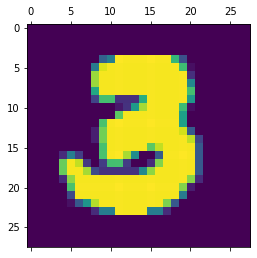

In [44]:
classifier = nn.get_classifier(10, x_train[0].shape)

index = 200

prediction = np.argmax(classifier.model.predict(np.array([x_test[index]])), axis=1)[0]
print('Prediction: {}:'.format(prediction))

plt.matshow(x_test[index])
plt.show()

# Evasion attacks
---
### Fast Gradient Sign Method attack

In [51]:
def perform_fgsm_attack(classifier, x_data, y_data):
    attack = FastGradientMethod(estimator=classifier)

    x_data_adv = attack.generate(x_data)

    y_data_predictions = np.argmax(classifier.model(x_data_adv), axis=1)
    accuracy_adv = np.sum(y_data_predictions == y_data) / len(y_data)

    perturbation = np.mean(np.abs((x_data_adv - x_data)))

    print('Accuracy on adversarial test data: {}'.format(accuracy_adv))
    print('Average perturbation: {}'.format(perturbation))
    
    return x_data_adv, attack

Accuracy on adversarial test data: 0.018
Average perturbation: 0.1668604016304016
Prediction: 5:


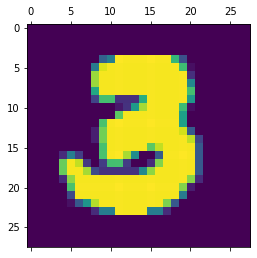

In [52]:
x_test_adv, attack = perform_fgsm_attack(classifier, x_test, y_test)

prediction = np.argmax(classifier.model.predict(np.array([x_test_adv[index]])), axis=1)[0]
print('Prediction: {}:'.format(prediction))

plt.matshow(x_test[index])
plt.show()

### Train neural network with adversial data

In [48]:
x_train_adv = attack.generate(x_train)

train_ds_adv = tf.data.Dataset.from_tensor_slices((x_train_adv, y_train)).shuffle(10000).batch(32)
test_ds_adv = tf.data.Dataset.from_tensor_slices((x_test_adv, y_test)).batch(32)

nn = NeuralNetworkTrainer(TfModel())
nn.train(train_ds_adv, test_ds_adv, epoches=5)
nn.test(x_test_adv, y_test)

classifier_v2 = nn.get_classifier(10, x_train_adv[0].shape)

Epoch 1, Train Accuraccy: 0.9731000065803528, Test Accurracy: 0.9735000133514404
Epoch 2, Train Accuraccy: 0.9773083329200745, Test Accurracy: 0.9741500020027161
Epoch 3, Train Accuraccy: 0.9793944358825684, Test Accurracy: 0.9746000170707703
Epoch 4, Train Accuraccy: 0.9807708263397217, Test Accurracy: 0.9748499989509583
Epoch 5, Train Accuraccy: 0.9818933606147766, Test Accurracy: 0.97461998462677
Accuracy on test data: 0.9737


### Perform same attack on it

Accuracy on adversarial test data: 0.1663
Average perturbation: 0.16532747447490692
Prediction: 9:


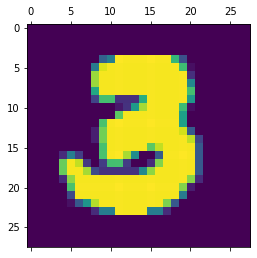

In [53]:
x_test_adv_new, _ = perform_fgsm_attaack(classifier_v2, x_test, y_test)

prediction = np.argmax(classifier_v2.model.predict(np.array([x_test_adv_new[index]])), axis=1)[0]
print('Prediction: {}:'.format(prediction))

plt.matshow(x_test[index])
plt.show()